# Regresion Lineal con PyTorch

### Entrena y evalua un modelo de regresion lineal para el conjunto de datos de calificaciones que considere los dos atributos de entrada

In [1]:
#importamos librerias utiles
#Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torchvision.datasets.utils as tutils
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url
#matrices, tablas y matematicas
import numpy as np
import pandas as pd
#graficacion
from matplotlib import pyplot as plt
#acceso a carpetas del sistema
import os
#para hacer graficas en 3D
from mpl_toolkits.mplot3d import Axes3D
#para tomar elementos de una secuencia
from itertools import islice as take
import time

In [2]:
#sembramos semilla aleatoria para reproducibilidad
torch.manual_seed(2020)
#descargamos
download_url('https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv','data')

Using downloaded and verified file: data\califs.csv


In [3]:
#cargamos los datos
calificaciones = pd.read_csv('data/califs.csv', names = ['Calificacion Anterior', 'Horas de estudio', 'Calificacion'])
#mostamos la cebecera, los primeros diez elementos
calificaciones.head(10)

,Calificacion Anterior,Horas de estudio,Calificacion
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770
5,6.489,10.437,6.039
6,6.148,10.460,6.871
7,6.834,10.518,6.272
8,6.381,10.768,7.236
9,6.274,10.948,7.279


###  Grafica los datos en 3D

In [4]:
#funcionpara observar un grafico 3D de puntos (x,y,z)
#x,y,z son las posiciones de los puntos a observar
def grafico3D(x,y,z):  
    #para hacer un grafico interactivo
    #%matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    #definimos los nombres de los ejes
    ax.set_ylabel('Horas de estudio')
    ax.set_xlabel('Calificacion Anterior')
    ax.set_zlabel('Calificacion')
    ax.set_title('Calificacion en funcion de la calif anterior y las horas de estudio \n puntos rojos representan alumnos con calificacion menor a 6.0')
    for i in range(x.shape[0]):
        if z[i] >= 6.0:
            plt.plot(x[i], y[i], z[i], 'o', color='gold')
        else:
            plt.plot(x[i], y[i], z[i], 'o', color='red')
    #plt.close(fig)

In [5]:
#Definimos las x,y,z a graficar
x = calificaciones['Calificacion Anterior'][:].to_numpy()
y = calificaciones['Horas de estudio'][:].to_numpy()
z = calificaciones['Calificacion'][:].to_numpy()

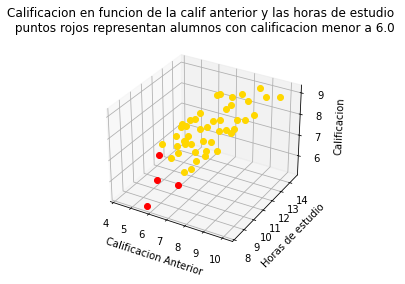

In [6]:
grafico3D(x,y,z)
#plt.close()

### Realiza la definicion de la arquitectura usando la interfaz de alto como la de medio nivel

In [7]:
## Definimos nuestra clase data set:
class DataSetCalif:
    #creamos la funcion que inicializa el dataset
    def __init__(self, x, y):
        self.x = x
        self.y = y
    #creamos la funcion que nos regresa un solo ejemplo
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    #creamos la funcion que nos dice la cantidad de elementos en el dataset
    def __len__(self):
        return len(self.x)

In [8]:
#antes de instanciar el data set es necesario pasar x,y,z a vectores columna, por defecto numpy los lee con un shape
#tipo (w,) y nosotros queremos (w,1) para esto usamos np.newaxis
#dado que vamos a usar x, y como variables independientes hay que pegarlas
x = x[:,np.newaxis]
y = y[:,np.newaxis]
z = z[:,np.newaxis]
X = np.concatenate((x,y),axis=1)
#pytorch pide que nuestros vectores sean del tipo float 32
x = np.float32(x)
y = np.float32(y)
z = np.float32(z)
X = np.float32(X)
#imprimimos el shape de nuestros vectores
print('El shape de x es {0}, el sahpe de y es {1}, el shape de z es {2}'.format(x.shape, y.shape, z.shape))
#imprimimos el tipo de x, y, z
print('El tipo de x es {0}, el tipo de y es {1}, el tipo de z es {2}'.format(x.dtype, y.dtype, z.dtype))
print('El shape de X es {0}, el tipo de X es {1}'.format(X.shape, X.dtype))

El shape de x es (50, 1), el sahpe de y es (50, 1), el shape de z es (50, 1)
El tipo de x es float32, el tipo de y es float32, el tipo de z es float32
El shape de X es (50, 2), el tipo de X es float32


In [9]:
#instanciamos el data set con nuestros datos
ds = DataSetCalif(X,z)
# instanciamos el cargador de datos de torch
trainDataL = DataLoader(ds, batch_size=16, shuffle = True)
#tomamos un elemento de los datos cargados y los mostramos esto para asegurar que si se cargaron bien
for X, z in take(trainDataL, 1):
    print(f'x shape={X.shape} dtype={X.dtype}')
    print(f'z shape={z.shape} dtype={z.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
z shape=torch.Size([16, 1]) dtype=torch.float32


In [10]:
#imprimimos la longitud del dataset
print('El tamaño total del data set es {}'.format(ds.__len__()))

El tamaño total del data set es 50


Dado que estamos haciendo clasificacion lineal y en la misma buscamos una funcion tal que $$f(x) = W^{T}\vec{x} + \vec{b}$$ sea la que presente el minimo error para los datos de entrada. Entonces nuestra arquitectura consiste unicamente de una neurona con funcion de activacion lineal.

#### Alto nivel

In [11]:
regLinear = nn.Sequential(
    nn.Linear(2, 1, True)
)

La documentacion nos dice que torch.nn.Linear(in_features: int, out_features: int, bias: bool = True), donde:

* in_features – size of each input sample
* out_features – size of each output sample
* bias – If set to False, the layer will not learn an additive bias. Default: True

2 es el tamaño de los datos (x,y), 1 es el tamaño de la salida (z), queremos un bias asi que ponemos True en el argumento

#### Medio nivel

In [12]:
class RegLinearMid(nn.Module):
    #definimos la funcion instanciadora
    def __init__(self):
        # se llama al instanciador de la clase padre implementado en torch
        super(RegLinearMid, self).__init__()
        #definimos las capas, estas deben ser atributos de la clase
        self.fc = nn.Linear(2, 1, True)
    #definimos la funcion de propagacion que usa el atributo de la clase
    #el nombre de la funcion forward no debe cambiarse, si se hace el codigo no jala esto por la clase padre
    def forward(self, x):
        return self.fc(x)

In [13]:
#instanciamos a partir de la clase RegLinearMid
regLinearMid = RegLinearMid()

In [14]:
#imprimimos ambos modelos
print('Alto nivel --> {0}'.format(regLinear))
print('Medio nivel --> {0}'.format(regLinearMid))

Alto nivel --> Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Medio nivel --> RegLinearMid(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


#### Probando ambas arquitecturas con un dato sintetico (buenas practicas)

In [15]:
#definimos un dato sintetico de puros ceros (tensor de dimension 1,2) con ceros
prueba = torch.zeros(8,2)
#predecimos con nuestros modelos el dato sintetico
prediccionAlto = regLinear(prueba)
prediccionMedio = regLinearMid(prueba)
print('El tipo del vector sintetico es {0}. El shape y tipo de la prediccion de alto nivel es {1}, {2}.'
      'El shape y tipo de la prediccion de medio nivel es {3}, {4}.'.format(prueba.dtype, prediccionAlto.shape,
                                                                            prediccionAlto.dtype, prediccionMedio.shape,
                                                                            prediccionMedio.dtype))

El tipo del vector sintetico es torch.float32. El shape y tipo de la prediccion de alto nivel es torch.Size([8, 1]), torch.float32.El shape y tipo de la prediccion de medio nivel es torch.Size([8, 1]), torch.float32.


### Ciclo de entrenamiento

In [16]:
def entrename(X, modelo, epochs, learningRate=0.001):
    #definimos el optimizador o el algoritmo a emplear para el entrenamiento.
    #Para nuestro caso usaremos descenso del gradiente estocastico SGD
    opt = optim.SGD(modelo.parameters(), lr=learningRate)
    #creamos una lista donde se guardaran las perdidas por cada epoco
    lossHistory = []
    #iteramos sobre todas las epocas
    for epoch in range(epochs):
        #iteramos sobre todos los ejemplos del batch
        for x, y in X:
            #hacemos la prediccion
            prediccion = modelo(x)
            #calculamos la perdida usando la funcion mean squared error
            loss = func.mse_loss(prediccion, y)
            #vaciamos los gradientes para que los calculos anteriores no interfieran con los nuevos
            opt.zero_grad()
            #hacemos la retropropagacion del error
            loss.backward()
            # actualizamos los parametros por descenso del gradiente
            opt.step()
            #almacemamos la perdida actual en el historial de perdidas
            lossHistory.append(loss.item())
    opt.zero_grad()
    #regresamos los parametros calculados (matriz de peso y el sesgo), asi como el historial de perdidas
    return modelo.parameters(), lossHistory

In [22]:
[wAlto,bAlto] , lossHistoryAlto = entrename(trainDataL, modelo=regLinear, epochs=50)

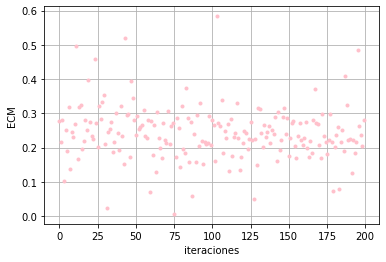

In [23]:
#plt.close()
#%matplotlib inline
plt.plot(np.arange(len(lossHistoryAlto)), lossHistoryAlto, '.', label='Perdida', color = 'pink')
plt.xlabel('iteraciones')
plt.ylabel('ECM')
plt.grid(True)
plt.show()

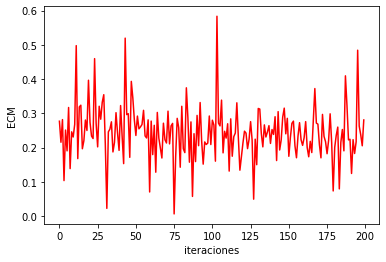

In [24]:
plt.plot(lossHistoryAlto, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

In [25]:
bAlto

Parameter containing:
tensor([-0.4423], requires_grad=True)